In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [3]:
df_2017 = pd.read_csv('/Users/rakesh/Documents/DSC167/hmda_2017_nationwide_all-records_labels.csv', 
                      dtype = {'msamd': str, 'state_code': str, 'county_code': str, 'census_tract_number': str,
                              'denial_reason_1':str, 'denial_reason_2': str, 'denial_reason_3': str})

/Users/rakesh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (34,36,38,44,46,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Rakesh Senthilvelan and Shin Ehara

## Introduction

Through our observation of the Housing Mortgage Disclosure Act in relation to fairness based on racial group in 2017, we noticed significant discrepancies when it came to the access to mortgages between Black applicants and White applicants across all income groups. In order to better understand the discrepancies and inequities in mortgage lending, we wanted to look into the areas of inframarginality and threshold testing, as well as intersectionality analysis, when it comes to algorithmic decision making in this area. Through this, we believe that a more fair and equitable classification model can be developed to determine the most likely scenario of someone getting their loan application originated or not. 

## Data Preparation

For the case of our classification system, we wanted to compare between whether or not a loan was approved or denied. To do this, we had to prepare our data as there are numerous data points that have end results such as "loan was withdrawn", "file closed for incompleteness", or "loan was purchased by financial institution" among others. To handle this, we merged the values for "loan originated" and "application approved but not accepted" into one value, "application denied by financial institutio" into another, and then dropped the remaining columns. We will use this subset of the data as the source for our classification model.

In [233]:
df_copy = df_2017.copy()

In [234]:
df_copy['action_taken'] = df_copy['action_taken'].replace(2,1)

In [235]:
no_drop = [1,3]
df = df_copy[df_copy.action_taken.isin(no_drop)]
# df.action_taken.value_counts()

In [26]:
df.columns
# Fairness: ['property_type', 'loan_type', 'loan_purpose', 'owner_occupancy', 'loan_amount_000s', 
# 'applicant_income_000s', 'number_of_owner_occupied_units', 'number_of_1_to_4_family_units']

Index(['as_of_year', 'respondent_id', 'agency_name', 'agency_abbr',
       'agency_code', 'loan_type_name', 'loan_type', 'property_type_name',
       'property_type', 'loan_purpose_name', 'loan_purpose',
       'owner_occupancy_name', 'owner_occupancy', 'loan_amount_000s',
       'preapproval_name', 'preapproval', 'action_taken_name', 'action_taken',
       'msamd_name', 'msamd', 'state_name', 'state_abbr', 'state_code',
       'county_name', 'county_code', 'census_tract_number',
       'applicant_ethnicity_name', 'applicant_ethnicity',
       'co_applicant_ethnicity_name', 'co_applicant_ethnicity',
       'applicant_race_name_1', 'applicant_race_1', 'applicant_race_name_2',
       'applicant_race_2', 'applicant_race_name_3', 'applicant_race_3',
       'applicant_race_name_4', 'applicant_race_4', 'applicant_race_name_5',
       'applicant_race_5', 'co_applicant_race_name_1', 'co_applicant_race_1',
       'co_applicant_race_name_2', 'co_applicant_race_2',
       'co_applicant_race_name_

In [237]:
df['loan_to_income'] = df['loan_amount_000s']/df['applicant_income_000s']

/Users/rakesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In order to train our model in a fair way, we wanted to look into which intersectional group of race and gender saw the highest level of loan acceptance in this dataset. To do this, we did preliminary data analysis comparisons between gender, then we look into the mixture of that gender and race to determine which group sees the highest acceptance rates. Our hypothesis is that this group will be represented by white males. Also, due to the nature of the dataset, the analysis of gender data only include the binary of male and female. 

In [32]:
df_race_action = df[['action_taken_name','action_taken','applicant_race_name_1','applicant_race_1', 'applicant_sex']]
male_action = df_race_action[df_race_action['applicant_sex'] == 1]
male_demo = male_action['action_taken'].value_counts(normalize=True) * 100
# male_demo

In [33]:
df_race_action = df[['action_taken_name','action_taken','applicant_race_name_1','applicant_race_1', 'applicant_sex']]
female_action = df_race_action[df_race_action['applicant_sex'] == 2]
female_demo = female_action['action_taken'].value_counts(normalize=True) * 100
# female_demo

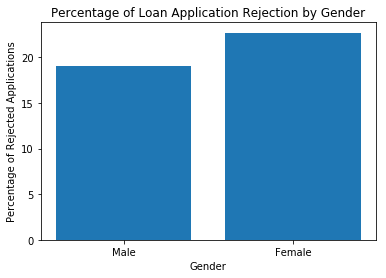

In [34]:
race = ['Male','Female']
reject = [19.005611, 22.710742]

plt.bar(race, reject)
plt.title('Percentage of Loan Application Rejection by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage of Rejected Applications')
plt.show()

Through the above graph, we can see that males face lower rates of loan rejection and higher rates of loan acceptance than females do. To further analyze, we will look into the intersection of race and gender to see which group has the lowest rejection rate.

In [36]:
white_male_action = df_race_action[(df_race_action['applicant_sex'] == 1) & (df_race_action['applicant_race_1'] == 5)]
white_male_demo = white_male_action['action_taken'].value_counts(normalize=True) * 100
white_male_demo

1    82.546645
3    17.453355
Name: action_taken, dtype: float64

In [37]:
black_male_action = df_race_action[(df_race_action['applicant_sex'] == 1) & (df_race_action['applicant_race_1'] == 3)]
black_male_demo = black_male_action['action_taken'].value_counts(normalize=True) * 100
black_male_demo

1    67.767625
3    32.232375
Name: action_taken, dtype: float64

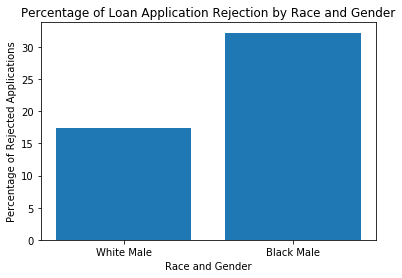

In [38]:
race = ['White Male','Black Male']
reject = [17.453355, 32.232375]

plt.bar(race, reject)
plt.title('Percentage of Loan Application Rejection by Race and Gender')
plt.xlabel('Race and Gender')
plt.ylabel('Percentage of Rejected Applications')
plt.show()

Based on the above graph, we can see that White males have a lower rate of rejection than Black males. From this analysis, we will develop our training set off of this demographic. 

## Building the Model 

Now, we will build our model that takes fairness into account. First, we will build the model using training data derived from White males. We believe that due to this intersectional group holding the lowest rejection rate in the dataset in the scope of our research, this will present the most fair subset of the data to pull from as we do not have training data that we can call inherently fair to build the model upon. In terms of the variables used, we will remove sensitive variables including race, ethnicity, sex, minority population percentage in an area, and geographic location to eliminate any biases. We will train the model using the variables of property type, loan type, loan purpose, owner occupancy, our engineered feature for loan to income ratio, and number of owner occupied units. We will develop this model using a Random Forest Classifier.

The reason why we picked these traits is based on correlation as well as the nature of the problem at hand. We created a correlation matrix for all the variables in this dataset and found significant correlations between property type, loan purposes, and purcharser type in relation to action taken with coefficients of 0.1322, 0.1544, and 0.3888 respectively. In addition, we trained on applicant income, loan amount, and loan to income ratio as well due to the financial nature of this situation as such factors would naturally be taken into consideration in any loan-based situation.

In [95]:
w_m_df =  df[(df['applicant_sex'] == 1) & (df['applicant_race_1'] == 5)]
w_m_df = w_m_df[['property_type', 'loan_type', 'loan_purpose', 'owner_occupancy', 'loan_amount_000s','applicant_income_000s',
                 'loan_to_income', 
                 'number_of_owner_occupied_units', 'action_taken','purchaser_type']]
w_m_df = w_m_df.astype({'action_taken': 'str', 'property_type':'str','loan_type':'str', 'loan_purpose':'str', 
                        'owner_occupancy':'str','purchaser_type':'str'})
w_m_df = w_m_df.dropna()


In [96]:
w_m_df.dtypes

property_type                      object
loan_type                          object
loan_purpose                       object
owner_occupancy                    object
loan_amount_000s                  float64
applicant_income_000s             float64
loan_to_income                    float64
number_of_owner_occupied_units    float64
action_taken                       object
purchaser_type                     object
dtype: object

In [98]:
clf = RandomForestClassifier(max_depth=10)
X = w_m_df[['loan_type', 'loan_purpose', 'loan_to_income', 'loan_amount_000s','applicant_income_000s','purchaser_type']]
y = w_m_df['action_taken']
clf.fit(X,y)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [99]:
df_no_na = df.copy()
df_no_na = df_no_na[(df_no_na['applicant_race_1'] == 3) | (df_no_na['applicant_race_1'] == 5)]
df_no_na = df_no_na[['applicant_race_1','applicant_sex','applicant_income_000s','loan_amount_000s','property_type', 'loan_type', 'loan_purpose', 'owner_occupancy', 'loan_to_income', 
                 'number_of_owner_occupied_units', 'action_taken', 'purchaser_type']]
df_no_na = df_no_na.astype({'action_taken': 'str', 'property_type':'str','loan_type':'str', 'loan_purpose':'str', 
                        'owner_occupancy':'str','purchaser_type':'str'})
df_no_na = df_no_na.dropna()

# print(clf.predict(df_no_na[['property_type', 'loan_type', 'loan_purpose', 'owner_occupancy', 
#                             'loan_to_income', 'number_of_owner_occupied_units']]))
# df_no_na.head()

,applicant_race_1,applicant_sex,applicant_income_000s,loan_amount_000s,property_type,loan_type,loan_purpose,owner_occupancy,loan_to_income,number_of_owner_occupied_units,action_taken,purchaser_type
1,5,1,60.0,168.0,1,1,3,1,2.800000,861.0,3,0
3,5,2,53.0,88.0,1,1,3,2,1.660377,573.0,1,3
9,5,2,31.0,94.0,1,1,3,2,3.032258,1019.0,1,0
10,3,2,26.0,95.0,1,2,3,1,3.653846,2517.0,3,0
11,5,1,36.0,38.0,1,1,1,2,1.055556,2450.0,3,0


In [101]:
a = clf.predict(df_no_na[['loan_type', 'loan_purpose', 'loan_to_income', 'loan_amount_000s',
                          'applicant_income_000s','purchaser_type']])

# print(a)

['3' '1' '3' ... '3' '1' '1']


In [102]:
# from collections import Counter

# d = Counter(a)
# d

Counter({'3': 942001, '1': 6466359})

In [90]:
# df_no_na.action_taken.value_counts()

1    5979301
3    1429059
Name: action_taken, dtype: int64

In [91]:
# 5979301 /(5979301 + 1429059)

0.807101841703157

In [103]:
# 6466359 / (7369719 + 38641)

0.8728462169764968

In [104]:
df.corr()

,as_of_year,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,applicant_ethnicity,...,edit_status,sequence_number,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,application_date_indicator,loan_to_income
as_of_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agency_code,NaN,1.000000,0.036319,-0.041578,0.084329,-0.068010,0.015522,0.004056,0.098279,-0.068370,...,NaN,NaN,0.028828,0.121705,0.062484,0.047174,-0.003060,-0.015068,NaN,0.000783
loan_type,NaN,0.036319,1.000000,-0.065528,-0.065511,-0.169073,-0.010770,-0.102986,-0.009801,-0.059329,...,NaN,NaN,0.042257,0.013418,-0.094489,-0.090389,0.036677,0.060239,NaN,0.001627
property_type,NaN,-0.041578,-0.065528,1.000000,-0.082090,0.166910,0.080551,0.047942,0.132283,0.126012,...,NaN,NaN,-0.030728,-0.010669,-0.090146,-0.084726,-0.032735,-0.003871,NaN,-0.000979
loan_purpose,NaN,0.084329,-0.065511,-0.082090,1.000000,-0.012291,-0.004703,0.427368,0.154475,0.042079,...,NaN,NaN,-0.024404,0.043269,0.040944,-0.003248,-0.031418,-0.035869,NaN,-0.000547
owner_occupancy,NaN,-0.068010,-0.169073,0.166910,-0.012291,1.000000,0.064720,0.040720,-0.023138,0.205924,...,NaN,NaN,-0.056932,0.043603,-0.027892,-0.067713,-0.088858,-0.020751,NaN,-0.001745
loan_amount_000s,NaN,0.015522,-0.010770,0.080551,-0.004703,0.064720,1.000000,0.000026,-0.017124,0.052129,...,NaN,NaN,0.000240,0.010084,0.046151,0.049876,-0.006819,-0.014856,NaN,0.527540
preapproval,NaN,0.004056,-0.102986,0.047942,0.427368,0.040720,0.000026,1.000000,0.114047,0.041647,...,NaN,NaN,-0.023161,0.018730,0.008913,-0.003443,-0.026191,-0.022391,NaN,-0.000062
action_taken,NaN,0.098279,-0.009801,0.132283,0.154475,-0.023138,-0.017124,0.114047,1.000000,-0.002397,...,NaN,NaN,-0.021527,0.078611,-0.058063,-0.077220,-0.036930,-0.014781,NaN,0.002781
applicant_ethnicity,NaN,-0.068370,-0.059329,0.126012,0.042079,0.205924,0.052129,0.041647,-0.002397,1.000000,...,NaN,NaN,-0.045061,-0.157640,0.063695,0.040091,-0.001976,-0.007374,NaN,0.001184


Our model, using Random Forest Classifier and the selected variables, approved 87.28% of the applicants compared to the 80.71% that were approved in our original sample. We believe that developing this training model using the fairness metrics brought up earlier were beneficial in creating a more equal lending system. Now, we will look into the fairness of this algorithm through the lenses of Individual Fairness and Intersectionality. 

## Intersectionality Analysis

One of the main characteristics we noticed in our data was that Black applicants were rejected a signficantly higher rate than White applicants, as seen earlier in the section titled "Data Preparation" as well as our first paper. When looking into the intersectionality between race and income in our first paper, we noticed that Black applicants in the dataset were consistently rejected at a higher rate than White applicants. That is represented by the following graph, brought from our first paper. 

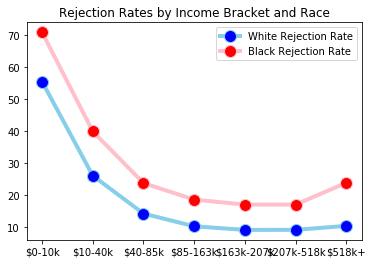

In [105]:
x_values = ['$0-10k', '$10-40k','$40-85k','$85-163k','$163k-207k','$207k-518k','$518k+']
y1_values = [55.494530, 26.015737, 14.133654, 10.164868,9.027158,9.058271,10.293484]
y2_values = [70.951658, 39.880038, 23.696660, 18.517326,16.957265,16.980620,23.787062]

df = pd.DataFrame(list(zip(x_values, y1_values, y2_values)),columns = ['Income Bracket', 
                                                                       'White Rejection Rate','Black Rejection Rate'])

plt.plot('Income Bracket', 'White Rejection Rate', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot('Income Bracket', 'Black Rejection Rate', data=df, marker='o', markerfacecolor='red', markersize = 12, color='pink', linewidth=4)

plt.legend()
plt.title('Rejection Rates by Income Bracket and Race')
plt.show()

For this intersectionality analysis, we will once again look into the areas of race and income, but we will also look into the area of sex as well as we were able to find a difference in rejection rates based on sex. For the case of our analysis, we will first look at the rejection rates on these different identities in the original data set and then compare those statistics on the predictions of our model. 

In [202]:
# # 0 - 10 range
# range_0_10 = np.arange(0.0,10.0)
# df_0_10 = df_no_na.loc[(df_no_na['applicant_income_000s'].isin(range_0_10))]
# white_male_action = df_0_10[(df_0_10['applicant_race_1'] == 5) & (df_0_10['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [203]:
# range_0_10 = np.arange(0.0,10.0)
# df_0_10 = df_no_na.loc[(df_no_na['applicant_income_000s'].isin(range_0_10))]
# white_female_action = df_0_10[(df_0_10['applicant_race_1'] == 5) & (df_0_10['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [204]:
# range_0_10 = np.arange(0.0,10.0)
# df_0_10 = df_no_na.loc[(df_no_na['applicant_income_000s'].isin(range_0_10))]
# black_male_action = df_0_10[(df_0_10['applicant_race_1'] == 3) & (df_0_10['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [205]:
# range_0_10 = np.arange(0.0,10.0)
# df_0_10 = df_no_na.loc[(df_no_na['applicant_income_000s'].isin(range_0_10))]
# black_female_action = df_0_10[(df_0_10['applicant_race_1'] == 3) & (df_0_10['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [206]:
# # 10 - 40
# range_10_40 = np.arange(10.0,40.0)
# df_10_40 = df_no_na.loc[(df_no_na['applicant_income_000s'].isin(range_10_40))]
# white_male_action = df_10_40[(df_10_40['applicant_race_1'] == 5) & (df_10_40['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [207]:
# white_female_action = df_10_40[(df_10_40['applicant_race_1'] == 5) & (df_10_40['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [208]:
# black_male_action = df_10_40[(df_10_40['applicant_race_1'] == 3) & (df_10_40['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [209]:
# black_female_action = df_10_40[(df_10_40['applicant_race_1'] == 3) & (df_10_40['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [210]:
# 40 - 85
# range_40_85 = np.arange(40.0,85.0)
# df_40_85 = df_no_na.loc[(df_no_na['applicant_income_000s'].isin(range_40_85))]
# white_male_action = df_40_85[(df_40_85['applicant_race_1'] == 5) & (df_40_85['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [211]:
# white_female_action = df_40_85[(df_40_85['applicant_race_1'] == 5) & (df_40_85['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [212]:
# black_male_action = df_40_85[(df_40_85['applicant_race_1'] == 3) & (df_40_85['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [213]:
# black_female_action = df_40_85[(df_40_85['applicant_race_1'] == 3) & (df_40_85['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [214]:
# # 85 - 163
# range_85_163 = np.arange(85.0,163.0)
# df_85_163 = df_no_na.loc[(df_no_na['applicant_income_000s'].isin(range_85_163))]
# white_male_action = df_85_163[(df_85_163['applicant_race_1'] == 5) & (df_85_163['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [215]:
# white_female_action = df_85_163[(df_85_163['applicant_race_1'] == 5) & (df_85_163['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [216]:
# black_male_action = df_85_163[(df_85_163['applicant_race_1'] == 3) & (df_85_163['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [217]:
# black_female_action = df_85_163[(df_85_163['applicant_race_1'] == 3) & (df_85_163['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [218]:
# # 163 - 207
# range_163_207 = np.arange(163.0,207.0)
# df_163_207 = df_no_na.loc[(df_no_na['applicant_income_000s'].isin(range_163_207))]
# white_male_action = df_163_207[(df_163_207['applicant_race_1'] == 5) & (df_163_207['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [219]:
# white_female_action = df_163_207[(df_163_207['applicant_race_1'] == 5) & (df_163_207['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [220]:
# black_male_action = df_163_207[(df_163_207['applicant_race_1'] == 3) & (df_163_207['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [221]:
# black_female_action = df_163_207[(df_163_207['applicant_race_1'] == 3) & (df_163_207['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [222]:
# # 207 - 518
# range_207_518 = np.arange(207.0,518.0)
# df_207_518 = df_no_na.loc[(df_no_na['applicant_income_000s'].isin(range_207_518))]
# white_male_action = df_207_518[(df_207_518['applicant_race_1'] == 5) & (df_207_518['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [223]:
# white_female_action = df_207_518[(df_207_518['applicant_race_1'] == 5) & (df_207_518['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [224]:
# black_male_action = df_207_518[(df_207_518['applicant_race_1'] == 3) & (df_207_518['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [225]:
# black_female_action = df_207_518[(df_207_518['applicant_race_1'] == 3) & (df_207_518['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [226]:
# # 518k+
# df_rich = df_no_na.loc[(df_no_na['applicant_income_000s'] >= 518.0)]
# white_male_action = df_rich[(df_rich['applicant_race_1'] == 5) & (df_rich['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [227]:
# white_female_action = df_rich[(df_rich['applicant_race_1'] == 5) & (df_rich['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [228]:
# black_male_action = df_rich[(df_rich['applicant_race_1'] == 3) & (df_rich['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [229]:
# black_female_action = df_rich[(df_rich['applicant_race_1'] == 3) & (df_rich['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

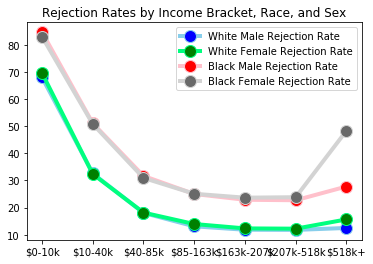

In [230]:
x_values = ['$0-10k', '$10-40k','$40-85k','$85-163k','$163k-207k','$207k-518k','$518k+']
y1_values = [68.033874, 32.591724, 18.026015, 13.075815, 11.818329, 11.753601, 12.478032]
y2_values = [69.660098, 32.385828, 18.140888, 13.930354, 12.311178, 12.210735, 15.628437]
y3_values = [84.727503, 51.126169, 31.680877, 25.012548, 22.879603, 22.708895, 27.770859]
y4_values = [83.093358, 50.829286, 30.939542, 25.096992, 23.656728, 23.830571, 48.351648]



df = pd.DataFrame(list(zip(x_values, y1_values, y2_values, y3_values, y4_values)),columns = ['Income Bracket', 
                                                                       'White Male Rejection Rate',
                                                                       'White Female Rejection Rate',
                                                                        'Black Male Rejection Rate',
                                                                      'Black Female Rejection Rate'])

plt.plot('Income Bracket', 'White Male Rejection Rate', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot('Income Bracket', 'White Female Rejection Rate', data=df, marker='o', markerfacecolor='green', markersize=12, color='springgreen', linewidth=4)
plt.plot('Income Bracket', 'Black Male Rejection Rate', data=df, marker='o', markerfacecolor='red', markersize = 12, color='pink', linewidth=4)
plt.plot('Income Bracket', 'Black Female Rejection Rate', data=df, marker='o', markerfacecolor='dimgray', markersize=12, color='lightgray', linewidth=4)


plt.legend()
plt.title('Rejection Rates by Income Bracket, Race, and Sex')
plt.show()

Based on the above graph, we can see that the main factor that affects rejection rates is race but there is a minor disparity between the genders. There is a significant jump in rejection rates for Black women in the highest income bracket which can be attributed to a small sample size of that demographic. Now, we will do the same analysis but this time, we will swap out the "action taken" column from the original dataset with the predictions from our Random Forest Classifier, which we believe will be more fair. 

In [139]:
df_2 = df_no_na.copy()
df_2.action_taken = a

In [173]:
# 0 - 10 range
# range_0_10 = np.arange(0.0,10.0)
# df_0_10 = df_2.loc[(df_2['applicant_income_000s'].isin(range_0_10))]
# white_male_action = df_0_10[(df_0_10['applicant_race_1'] == 5) & (df_0_10['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [174]:
# white_female_action = df_0_10[(df_0_10['applicant_race_1'] == 5) & (df_0_10['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [175]:
# black_male_action = df_0_10[(df_0_10['applicant_race_1'] == 3) & (df_0_10['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [176]:
# black_female_action = df_0_10[(df_0_10['applicant_race_1'] == 3) & (df_0_10['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [177]:
# 10 - 40
# range_10_40 = np.arange(10.0,40.0)
# df_10_40 = df_2.loc[(df_2['applicant_income_000s'].isin(range_10_40))]
# white_male_action = df_10_40[(df_10_40['applicant_race_1'] == 5) & (df_10_40['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [178]:
# white_female_action = df_10_40[(df_10_40['applicant_race_1'] == 5) & (df_10_40['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [179]:
# black_male_action = df_10_40[(df_10_40['applicant_race_1'] == 3) & (df_10_40['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [180]:
# black_female_action = df_10_40[(df_10_40['applicant_race_1'] == 3) & (df_10_40['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [181]:
# 40 - 85
# range_40_85 = np.arange(40.0,85.0)
# df_40_85 = df_2.loc[(df_2['applicant_income_000s'].isin(range_40_85))]
# white_male_action = df_40_85[(df_40_85['applicant_race_1'] == 5) & (df_40_85['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [182]:
# white_female_action = df_40_85[(df_40_85['applicant_race_1'] == 5) & (df_40_85['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [183]:
# black_male_action = df_40_85[(df_40_85['applicant_race_1'] == 3) & (df_40_85['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [184]:
# black_female_action = df_40_85[(df_40_85['applicant_race_1'] == 3) & (df_40_85['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [185]:
# 85 - 163
# range_85_163 = np.arange(85.0,163.0)
# df_85_163 = df_2.loc[(df_2['applicant_income_000s'].isin(range_85_163))]
# white_male_action = df_85_163[(df_85_163['applicant_race_1'] == 5) & (df_85_163['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [186]:
# white_female_action = df_85_163[(df_85_163['applicant_race_1'] == 5) & (df_85_163['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [187]:
# black_male_action = df_85_163[(df_85_163['applicant_race_1'] == 3) & (df_85_163['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [188]:
# black_female_action = df_85_163[(df_85_163['applicant_race_1'] == 3) & (df_85_163['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [189]:
# 163 - 207
# range_163_207 = np.arange(163.0,207.0)
# df_163_207 = df_2.loc[(df_2['applicant_income_000s'].isin(range_163_207))]
# white_male_action = df_163_207[(df_163_207['applicant_race_1'] == 5) & (df_163_207['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [190]:
# white_female_action = df_163_207[(df_163_207['applicant_race_1'] == 5) & (df_163_207['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [191]:
# black_male_action = df_163_207[(df_163_207['applicant_race_1'] == 3) & (df_163_207['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [192]:
# black_female_action = df_163_207[(df_163_207['applicant_race_1'] == 3) & (df_163_207['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [193]:
# 207 - 518
# range_207_518 = np.arange(207.0,518.0)
# df_207_518 = df_2.loc[(df_2['applicant_income_000s'].isin(range_207_518))]
# white_male_action = df_207_518[(df_207_518['applicant_race_1'] == 5) & (df_207_518['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [194]:
# white_female_action = df_207_518[(df_207_518['applicant_race_1'] == 5) & (df_207_518['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [195]:
# black_male_action = df_207_518[(df_207_518['applicant_race_1'] == 3) & (df_207_518['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [196]:
# black_female_action = df_163_207[(df_163_207['applicant_race_1'] == 3) & (df_163_207['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

In [197]:
# # Rich
# df_rich = df_2.loc[(df_2['applicant_income_000s'] >= 518.0)]
# white_male_action = df_rich[(df_rich['applicant_race_1'] == 5) & (df_rich['applicant_sex'] == 1)]
# white_male_action['action_taken'].value_counts(normalize=True) * 100

In [198]:
# white_female_action = df_rich[(df_rich['applicant_race_1'] == 5) & (df_rich['applicant_sex'] == 2)]
# white_female_action['action_taken'].value_counts(normalize=True) * 100

In [199]:
# black_male_action = df_rich[(df_rich['applicant_race_1'] == 3) & (df_rich['applicant_sex'] == 1)]
# black_male_action['action_taken'].value_counts(normalize=True) * 100

In [200]:
# black_female_action = df_rich[(df_rich['applicant_race_1'] == 3) & (df_rich['applicant_sex'] == 2)]
# black_female_action['action_taken'].value_counts(normalize=True) * 100

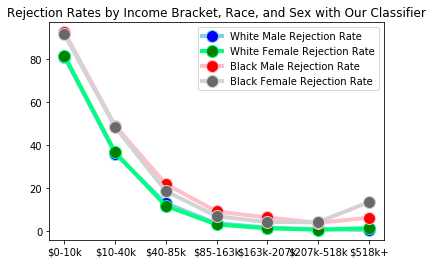

In [201]:
x_values = ['$0-10k', '$10-40k','$40-85k','$85-163k','$163k-207k','$207k-518k','$518k+']
y1_values = [80.991736, 36.088083, 13.076467, 3.767659, 1.835314, 0.996151, 0.732279]
y2_values = [81.669091, 36.783519, 11.86494, 3.28309, 1.467415, 0.862297, 1.559844]
y3_values = [92.585551, 49.148675, 22.042385, 9.314835, 6.502551, 4.035639, 6.41345]
y4_values = [91.546679, 48.576637, 18.718763, 7.105945, 4.343878, 4.343878, 13.626374]



df = pd.DataFrame(list(zip(x_values, y1_values, y2_values, y3_values, y4_values)),columns = ['Income Bracket', 
                                                                       'White Male Rejection Rate',
                                                                       'White Female Rejection Rate',
                                                                        'Black Male Rejection Rate',
                                                                      'Black Female Rejection Rate'])

plt.plot('Income Bracket', 'White Male Rejection Rate', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot('Income Bracket', 'White Female Rejection Rate', data=df, marker='o', markerfacecolor='green', markersize=12, color='springgreen', linewidth=4)
plt.plot('Income Bracket', 'Black Male Rejection Rate', data=df, marker='o', markerfacecolor='red', markersize = 12, color='pink', linewidth=4)
plt.plot('Income Bracket', 'Black Female Rejection Rate', data=df, marker='o', markerfacecolor='dimgray', markersize=12, color='lightgray', linewidth=4)


plt.legend()
plt.title('Rejection Rates by Income Bracket, Race, and Sex with Our Classifier')
plt.show()

From the above graph, we can see that using our unsensitive variables, a more equitable system was created compared to the original dataset. One flaw we saw was that there was a high rejection rate at low income ranges and a very low rejection rate at high income brackets. We believe that there is additional work that would need to be done to create a truly fair system. 

## Individual Fairness


Now, we want to examine the individual fairness of our model, that is, whether the model produces the same outcome for individuals whose input variables are very close. For example, suppose one person with a 100k income and a 50k loan gets his loan accepted. We consider our model individually fair if another person with a 100k income and 50k loan also gets his loan taken regardless of race and gender. To do this, we first sample 500 random instances from our dataset. We had to sample and limit the scope of our investigation simply because of limited computational resources.

In [44]:
df_if = df.copy()
df_if = df_if[['loan_type', 'loan_purpose', 'loan_to_income', 'loan_amount_000s',
                          'applicant_income_000s','purchaser_type','action_taken']]
df_if = df_if.dropna()
df_if.head()

NameError: name 'df' is not defined

In [45]:
#samp = df_if.sample(n=500)
samp = pd.read_csv('sample_2.csv',index_col=0)
samp.head()

,loan_type,applicant_race_1,applicant_sex,loan_purpose,loan_to_income,loan_amount_000s,applicant_income_000s,purchaser_type,action_taken
4452886,3,5,1,3,3.437500,165.0,48.0,2,1
2530809,1,5,2,3,1.786885,109.0,61.0,0,1
8214276,2,5,1,3,2.528090,225.0,89.0,0,3
1315020,2,5,1,3,5.689655,165.0,29.0,0,3
10948711,1,5,2,3,3.527473,321.0,91.0,0,3


Next, we define how to compare "distance/similarity" between different individuals. To compare the similarity of different instances, we employ different measures for categorical and numerical values. For categorical values ("loan_type", "purchaser_type", "loan_purpose"), we use Jaccard distance to measure the similarity between pairs of individuals in the sample. For numerical values ("loan_amount_000s", "applicant_income_000s"), we use Euclidean distance to calculate the similarity between instances. To calculate the Euclidean distance with better accuracy, we normalized each of these two columns first, then calculated the distance.

In [21]:
# Normalize numerical columns

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

loan = samp['loan_amount_000s'] 
loan_scaled =(loan-loan.min())/(loan.max()-loan.min())
samp['loan_amount_000s'] = loan_scaled

income = samp['applicant_income_000s']
income_scaled =(income-income.min())/(income.max()-income.min())
samp['applicant_income_000s'] = income_scaled

samp.head()

,loan_type,applicant_race_1,applicant_sex,loan_purpose,loan_to_income,loan_amount_000s,applicant_income_000s,purchaser_type,action_taken
4452886,3,5,1,3,3.437500,0.136060,0.029283,2,1
2530809,1,5,2,3,1.786885,0.089316,0.037383,0,1
8214276,2,5,1,3,2.528090,0.186144,0.054829,0,3
1315020,2,5,1,3,5.689655,0.136060,0.017445,0,3
10948711,1,5,2,3,3.527473,0.266277,0.056075,0,3


In [22]:
# Calculate Jaccard distance with categorical values

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard

res = pdist(samp[['loan_type','loan_purpose','purchaser_type','action_taken']], 'jaccard')
squareform(res)
jaccard = pd.DataFrame(1-squareform(res), index=samp.index, columns= samp.index)

In [23]:
jaccard

,4452886,2530809,8214276,1315020,10948711,8583422,7424132,4718731,10887527,5641634,...,11394612,12145271,7749920,421889,7940995,3510280,5191310,1324029,2327214,3205554
4452886,1.00,0.500000,0.250000,0.250000,0.250000,0.250000,0.250000,0.50,0.000000,0.250000,...,0.50,0.50,0.000000,0.250000,0.50,0.250000,0.250000,0.000000,0.50,0.500000
2530809,0.50,1.000000,0.333333,0.333333,0.666667,0.666667,0.666667,0.75,0.333333,0.666667,...,0.75,0.75,0.333333,0.666667,0.75,0.666667,0.666667,0.000000,0.25,1.000000
8214276,0.25,0.333333,1.000000,1.000000,0.666667,0.000000,0.000000,0.25,0.333333,0.000000,...,0.25,0.25,0.333333,0.000000,0.25,0.000000,0.000000,0.666667,0.00,0.333333
1315020,0.25,0.333333,1.000000,1.000000,0.666667,0.000000,0.000000,0.25,0.333333,0.000000,...,0.25,0.25,0.333333,0.000000,0.25,0.000000,0.000000,0.666667,0.00,0.333333
10948711,0.25,0.666667,0.666667,0.666667,1.000000,0.333333,0.333333,0.50,0.666667,0.333333,...,0.50,0.50,0.666667,0.333333,0.50,0.333333,0.333333,0.333333,0.00,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3510280,0.25,0.666667,0.000000,0.000000,0.333333,1.000000,0.666667,0.50,0.666667,1.000000,...,0.50,0.50,0.333333,0.666667,0.50,1.000000,0.666667,0.333333,0.50,0.666667
5191310,0.25,0.666667,0.000000,0.000000,0.333333,0.666667,1.000000,0.50,0.333333,0.666667,...,0.50,0.50,0.666667,1.000000,0.50,0.666667,1.000000,0.000000,0.25,0.666667
1324029,0.00,0.000000,0.666667,0.666667,0.333333,0.333333,0.000000,0.00,0.666667,0.333333,...,0.00,0.00,0.333333,0.000000,0.00,0.333333,0.000000,1.000000,0.25,0.000000
2327214,0.50,0.250000,0.000000,0.000000,0.000000,0.500000,0.250000,0.25,0.250000,0.500000,...,0.50,0.25,0.000000,0.250000,0.50,0.500000,0.250000,0.250000,1.00,0.250000


In [25]:
n = 500
columns = jaccard.columns
indices = jaccard.index
lists = []

for i in range(1, n):
    idx = indices[i]
    a = jaccard[idx][:i]
    for j in range(i):
        col = columns[j]
        val = a[col]
        lst = [idx, col, val]
        lists.append(lst)

jaccard_df = pd.DataFrame(lists)
jaccard_df = jaccard_df.rename(columns={0:"instance 1", 1:"instance 2", 2:"jaccard"})
jaccard_df.head()

,instance 1,instance 2,jaccard
0,2530809,4452886,0.500000
1,8214276,4452886,0.250000
2,8214276,2530809,0.333333
3,1315020,4452886,0.250000
4,1315020,2530809,0.333333


In [26]:
# Calculate Euclidean distance with numerical variables

res = pdist(samp[['loan_to_income','loan_amount_000s','applicant_income_000s']], 'euclidean')

squareform(res)
euc = pd.DataFrame(squareform(res), index=samp.index, columns= samp.index)

In [27]:
euc

,4452886,2530809,8214276,1315020,10948711,8583422,7424132,4718731,10887527,5641634,...,11394612,12145271,7749920,421889,7940995,3510280,5191310,1324029,2327214,3205554
4452886,0.000000,1.651296,0.911146,2.252186,0.160528,2.994671,3.311876,2.361391,3.479912,3.259256,...,1.534563,2.419027,3.200285,3.262778,2.545092,2.998965,3.378982,0.257034,0.555353,1.814898
2530809,1.651296,0.000000,0.747706,3.903101,1.749660,1.345561,1.660771,0.710268,5.129918,1.608136,...,0.130975,0.774811,1.549435,1.611661,0.895514,1.347812,1.727944,1.902875,1.095945,0.163792
8214276,0.911146,0.747706,0.000000,3.162183,1.002591,2.087028,2.406595,1.455034,4.390439,2.353906,...,0.626152,1.509299,2.295727,2.357471,1.636962,2.092981,2.473941,1.166333,0.360974,0.909890
1315020,2.252186,3.903101,3.162183,0.000000,2.166445,5.245984,5.563039,4.613233,1.228965,5.510458,...,3.786653,4.670498,5.451272,5.513969,4.796984,5.250433,5.630069,2.000586,2.807376,4.066784
10948711,0.160528,1.749660,1.002591,2.166445,0.000000,3.088671,3.409175,2.457609,3.395368,3.356486,...,1.628689,2.509951,3.298227,3.360052,2.639016,3.095525,3.476495,0.244345,0.661737,1.912308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3510280,2.998965,1.347812,2.092981,5.250433,3.095525,0.087449,0.314363,0.638021,6.476648,0.261603,...,1.466850,0.596225,0.210036,0.265337,0.459330,0.000000,0.382828,3.250044,2.443651,1.184289
5191310,3.378982,1.727944,2.473941,5.630069,3.476495,0.408667,0.069621,1.019125,6.855806,0.121774,...,1.847922,0.977478,0.179417,0.117845,0.841619,0.382828,0.000000,3.629490,2.823688,1.564661
1324029,0.257034,1.902875,1.166333,2.000586,0.244345,3.246635,3.562501,2.613028,3.227091,3.509934,...,1.787829,2.672402,3.450686,3.513436,2.797429,3.250044,3.629490,0.000000,0.808109,2.066621
2327214,0.555353,1.095945,0.360974,2.807376,0.661737,2.439750,2.756572,1.806065,4.034741,2.703949,...,0.979797,1.864660,2.645022,2.707471,1.990005,2.443651,2.823688,0.808109,0.000000,1.259553


In [28]:
n = 500
columns = euc.columns
indices = euc.index
lists = []

for i in range(1, n):
    idx = indices[i]
    a = euc[idx][:i]
    for j in range(i):
        col = columns[j]
        val = a[col]
        lst = [idx, col, val]
        lists.append(lst)

euc_df = pd.DataFrame(lists)
euc_df = euc_df.rename(columns={0:"instance 1", 1:"instance 2", 2:"euc"})
euc_df.head()

,instance 1,instance 2,euc
0,2530809,4452886,1.651296
1,8214276,4452886,0.911146
2,8214276,2530809,0.747706
3,1315020,4452886,2.252186
4,1315020,2530809,3.903101


This table below consists of all possible pairs of instances from the sample with each pair's Jaccard and Euclidean distances. For clarification, the higher the Jaccard distance, the more similar a pair is. And the lower Euclidean distance, the more similar a pair is.

In [29]:
distance_df = jaccard_df.merge(euc_df, on=['instance 1', 'instance 2'])
distance_df.head()

,instance 1,instance 2,jaccard,euc
0,2530809,4452886,0.500000,1.651296
1,8214276,4452886,0.250000,0.911146
2,8214276,2530809,0.333333,0.747706
3,1315020,4452886,0.250000,2.252186
4,1315020,2530809,0.333333,3.903101


Now, we want to define "close distance" for each of Jaccard and Euclidean distances. For Jaccard distance, we define it to be 1.00 only as it's the highest similarity score of 7 possible scores (1.0, 7.5, 0.67, 0.5, 0.33, 0.25, 0.0). For Euclidean distance, we define it to be the lowest 10% distance of all, which is 0.304677 as calculated below.

In [30]:
distance_df['euc'].quantile(np.linspace(.1, 1, 9, 0))

0.1    0.304677
0.2    0.568797
0.3    0.841212
0.4    1.126108
0.5    1.438945
0.6    1.792070
0.7    2.220929
0.8    2.763580
0.9    3.693413
Name: euc, dtype: float64

With these definitions of "similar instance," we slice rows of similar pairs and compare outcomes of two instances within each pair.

In [46]:
close_distance_df = distance_df[(distance_df.jaccard==1.0) & (distance_df.euc < 0.304677)]
close_distance_df = close_distance_df.reset_index(drop=True)
close_distance_df.head()

,instance 1,instance 2,jaccard,euc
0,5641634,8583422,1.0,0.289155
1,10689407,9130746,1.0,0.210693
2,12706871,8583422,1.0,0.066672
3,12706871,5641634,1.0,0.235142
4,12557361,11923108,1.0,0.137827


For these selected pairs of instances, which we consider to be "similar," we want to know what action was taken in our model for their loan application.

In [32]:
action_1s = []
action_2s = []

for i in range(close_distance_df.shape[0]):
    ins_1 = close_distance_df.iloc[i]['instance 1']
    action_1 = samp.loc[int(ins_1)]['action_taken']
    action_1s.append(action_1)
    
    ins_2 = close_distance_df.iloc[i]['instance 2']
    action_2 = samp.loc[int(ins_2)]['action_taken']
    action_2s.append(action_2)
    
close_distance_df['action_1'] = action_1s
close_distance_df['action_2'] = action_2s
close_distance_df['same outcome'] = close_distance_df['action_1'] == close_distance_df['action_2']

close_distance_df.head()

,instance 1,instance 2,jaccard,euc,action_1,action_2,same outcome
0,5641634,8583422,1.0,0.289155,1.0,1.0,True
1,10689407,9130746,1.0,0.210693,1.0,1.0,True
2,12706871,8583422,1.0,0.066672,1.0,1.0,True
3,12706871,5641634,1.0,0.235142,1.0,1.0,True
4,12557361,11923108,1.0,0.137827,1.0,1.0,True


In [39]:
print(close_distance_df.shape)
close_distance_df['same outcome'].value_counts()

(1267, 10)


True    1267
Name: same outcome, dtype: int64

As shown above, all 1,267 pairs of similar individuals experienced the same outcome (loan action). Thus, it seems that our model performs very fair at the individual level; that is, the model produces the same result for individuals whose input variables are very close. Finally, we explore whether these same outcomes between similar individuals are attributed to their race or gender backgrounds. To do this, we compare the race and gender of each instance within a pair.

In [34]:
# Race

race_1s = []
race_2s = []

for i in range(close_distance_df.shape[0]):
    ins_1 = close_distance_df.iloc[i]['instance 1']
    race_1 = samp.loc[int(ins_1)]['applicant_race_1']
    race_1s.append(race_1)
    
    ins_2 = close_distance_df.iloc[i]['instance 2']
    race_2 = samp.loc[int(ins_2)]['applicant_race_1']
    race_2s.append(race_2)
    
close_distance_df['race_1'] = race_1s
close_distance_df['race_2'] = race_2s
close_distance_df['same race'] = close_distance_df['race_1'] == close_distance_df['race_2']

close_distance_df.head()

,instance 1,instance 2,jaccard,euc,action_1,action_2,same outcome,race_1,race_2,same race
0,5641634,8583422,1.0,0.289155,1.0,1.0,True,5.0,5.0,True
1,10689407,9130746,1.0,0.210693,1.0,1.0,True,5.0,5.0,True
2,12706871,8583422,1.0,0.066672,1.0,1.0,True,5.0,5.0,True
3,12706871,5641634,1.0,0.235142,1.0,1.0,True,5.0,5.0,True
4,12557361,11923108,1.0,0.137827,1.0,1.0,True,5.0,3.0,False


In [40]:
close_distance_df['same race'].value_counts()

True     1117
False     150
Name: same race, dtype: int64

As shown above, 10+% of pairs in the sample consisted of two individuals with different races yet all of them experienced the same loan action. None of the pairs with different racial backgrounds experienced different outcomes with our model.

In [42]:
# Sex

sex_1s = []
sex_2s = []

for i in range(close_distance_df.shape[0]):
    ins_1 = close_distance_df.iloc[i]['instance 1']
    sex_1 = samp.loc[int(ins_1)]['applicant_sex']
    sex_1s.append(sex_1)
    
    ins_2 = close_distance_df.iloc[i]['instance 2']
    sex_2 = samp.loc[int(ins_2)]['applicant_sex']
    sex_2s.append(sex_2)
    
close_distance_df['sex_1'] = sex_1s
close_distance_df['sex_2'] = sex_2s
close_distance_df['same sex'] = close_distance_df['sex_1'] == close_distance_df['sex_2']

close_distance_df.head()

,instance 1,instance 2,jaccard,euc,action_1,action_2,same outcome,race_1,race_2,same race,sex_1,sex_2,same sex
0,5641634,8583422,1.0,0.289155,1.0,1.0,True,5.0,5.0,True,1.0,1.0,True
1,10689407,9130746,1.0,0.210693,1.0,1.0,True,5.0,5.0,True,2.0,1.0,False
2,12706871,8583422,1.0,0.066672,1.0,1.0,True,5.0,5.0,True,1.0,1.0,True
3,12706871,5641634,1.0,0.235142,1.0,1.0,True,5.0,5.0,True,1.0,1.0,True
4,12557361,11923108,1.0,0.137827,1.0,1.0,True,5.0,3.0,False,1.0,2.0,False


In [43]:
close_distance_df['same sex'].value_counts()

True     688
False    579
Name: same sex, dtype: int64

As shown above, nearly half of the pairs in the sample consisted of two individuals with different genders, yet all of them experienced the same loan action. Furthermore, none of the pairs with different genders experienced different outcomes with our model. Thus, to summarize what we found in this individual fairness analysis, our model is very fair in producing the same loan action for individuals with similar input variables. This fairness is not significantly attributed to their race and gender.